## Customer data prediction

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('E:\Sebnewrepo\Data/feature_eng1.csv')

order_new = pd.read_csv("E:\Sebnewrepo\Data\order_new.csv")
order_new.drop('Unnamed: 0', axis = 1, inplace = True)
order_new.drop('count', axis = 1, inplace = True)
order_product_new = pd.read_csv("E:\Sebnewrepo\Data\order_product_new.csv")

In [3]:
df.drop('Unnamed: 0', axis = 1, inplace = True)
df.head()

,user_id,product_id,user_orders,sum_days_since_prior_order,avg_days_since_prior_order,total_products,distinct_products,reordered_ratio,up_orders,up_first_order,up_last_order,up_average_cart_position,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,user_average_basket,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order
0,1,196,10,176.0,17.6,59,18,0.759259,10,1,10,1.400000,35791,0.582500,4.473875,0.776480,5.9,1.0,0,1.000000
1,1,10258,10,176.0,17.6,59,18,0.759259,9,2,10,3.333333,1946,0.552962,3.493716,0.713772,5.9,0.9,0,1.000000
2,1,10326,10,176.0,17.6,59,18,0.759259,1,5,5,5.000000,5526,0.521581,2.873635,0.652009,5.9,0.1,5,0.166667
3,1,12427,10,176.0,17.6,59,18,0.759259,10,1,10,3.300000,6476,0.529482,3.857058,0.740735,5.9,1.0,0,1.000000
4,1,13032,10,176.0,17.6,59,18,0.759259,3,2,10,6.333333,3751,0.479782,2.916796,0.657158,5.9,0.3,0,0.333333


#### 1. Merge dataset

In [4]:
# join order new table with eval set
od_1 = pd.DataFrame({
    'user_id': order_new['user_id'],
    'eval_set': order_new['eval_set']
    })
od_1 = od_1[od_1['eval_set'] != 'prior']

In [5]:
df_1 = pd.merge(df, od_1, on = 'user_id', how = 'left')
df_1.head()

,user_id,product_id,user_orders,sum_days_since_prior_order,avg_days_since_prior_order,total_products,distinct_products,reordered_ratio,up_orders,up_first_order,...,up_average_cart_position,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,user_average_basket,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,eval_set
0,1,196,10,176.0,17.6,59,18,0.759259,10,1,...,1.400000,35791,0.582500,4.473875,0.776480,5.9,1.0,0,1.000000,train
1,1,10258,10,176.0,17.6,59,18,0.759259,9,2,...,3.333333,1946,0.552962,3.493716,0.713772,5.9,0.9,0,1.000000,train
2,1,10326,10,176.0,17.6,59,18,0.759259,1,5,...,5.000000,5526,0.521581,2.873635,0.652009,5.9,0.1,5,0.166667,train
3,1,12427,10,176.0,17.6,59,18,0.759259,10,1,...,3.300000,6476,0.529482,3.857058,0.740735,5.9,1.0,0,1.000000,train
4,1,13032,10,176.0,17.6,59,18,0.759259,3,2,...,6.333333,3751,0.479782,2.916796,0.657158,5.9,0.3,0,0.333333,train


In [6]:
# Split dataset into two
df_train = df_1[df_1['eval_set'] == 'train']
df_test = df_1[df_1['eval_set'] == 'Test']

In [7]:
# pre-process order_product_new dataset, only leave rows with eval_set = train
v = order_new[order_new['eval_set'] == 'train']
tt = pd.merge(v, order_product_new, on = 'order_id', how = 'left')
order_new_train = pd.DataFrame({
    'user_id': tt['user_id'],
    'product_id': tt['product_id'],
    'reordered': tt['reordered']
})

In [8]:
# df_train left join order_product_new

train = pd.merge(df_train, order_new_train, on = ['user_id', 'product_id'], how = 'left')
train.head()

,user_id,product_id,user_orders,sum_days_since_prior_order,avg_days_since_prior_order,total_products,distinct_products,reordered_ratio,up_orders,up_first_order,...,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,user_average_basket,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,eval_set,reordered
0,1,196,10,176.0,17.6,59,18,0.759259,10,1,...,35791,0.582500,4.473875,0.776480,5.9,1.0,0,1.000000,train,1.0
1,1,10258,10,176.0,17.6,59,18,0.759259,9,2,...,1946,0.552962,3.493716,0.713772,5.9,0.9,0,1.000000,train,1.0
2,1,10326,10,176.0,17.6,59,18,0.759259,1,5,...,5526,0.521581,2.873635,0.652009,5.9,0.1,5,0.166667,train,NaN
3,1,12427,10,176.0,17.6,59,18,0.759259,10,1,...,6476,0.529482,3.857058,0.740735,5.9,1.0,0,1.000000,train,NaN
4,1,13032,10,176.0,17.6,59,18,0.759259,3,2,...,3751,0.479782,2.916796,0.657158,5.9,0.3,0,0.333333,train,1.0


In [9]:
train.drop('eval_set', axis = 1, inplace = True)
test = df_test.drop('eval_set', axis = 1)

In [10]:
# Ready to train and test
train = train.fillna(0)
test = test.fillna(0)

#### 2. Xgboost Model tune and train

In [11]:
# Kfold and cross validation for xgboost
def shuffle(df):
    
    a = df.sample(frac = 1).reset_index().drop('index', axis = 1)

    return a

def kfold_index(x_train, k):
    if k < 1:
        print('K cannot smaller than 1')
        return
    else:
        l = x_train.shape[0] 
        tail = l % k
        q = l // k
        index = [0]
        output_index = []
        # first n_examples % k sub_example have n_examples // k + 1 elements
        for i in range(1,tail):
            index.append((i*q)+1)
        for j in range(tail,k+1):
            index.append(j*q+tail)          
        for m in range(len(index)-1):
            output_index.append([index[m],index[m+1]])
        if [0, 0] in output_index:
             output_index.remove([0, 0])    
        return output_index

# the evaluation method here is auc,
# the return include mean of auc for all k eval_sets and the mean of best boosting round 

def cv_xgboost(x_train, y_train, param, num_boosting_round, early_stoping_rounds, kfold):
    
    import xgboost as xgb
    from sklearn import metrics
    # get kfold index
    index = kfold_index(x_train, kfold)

    #train each sub-combination
    auc = []
    br = []
    for i in range(kfold):
        #print(index)
        cv_xtest = x_train.iloc[index[i][0]:index[i][1],:]
        cv_ytest = y_train.iloc[index[i][0]:index[i][1],]
        
        # drop the test sub-set 
        cv_xtrain = x_train.drop(x_train.index[index[i][0]:index[i][1]])
        cv_ytrain = y_train.drop(y_train.index[index[i][0]:index[i][1]])
        
        # make the dmatrix for xgboost
        
        d_cvtrain = xgb.DMatrix(data = cv_xtrain, label = cv_ytrain)
        d_cvtest = xgb.DMatrix(data = cv_xtest, label = cv_ytest)
        #print('safe')
        
        # use xgb.train to train the model
        xg_l = xgb.train(params = param, 
                         dtrain = d_cvtrain, 
                         num_boost_round = num_boosting_round, 
                         early_stopping_rounds = early_stoping_rounds, 
                         evals = [(d_cvtest, 'test_evalset')],
                         verbose_eval = False)
        
        # calculate the auc as the evaluation metric
        fpr, tpr, threshold = roc_curve(cv_ytest, xg_l.predict(d_cvtest))
        aa = metrics.auc(fpr, tpr)
        auc.append(aa)  
        
        #get the number of boosting round
        
        bb = xg_l.best_iteration
        br.append(bb)
        #xg_l.best_ntree_limit
        
    return np.mean(auc), np.mean(br)

In [12]:
# too many records in train dataset, it is very slow to tune the parameter with this size of data
# shuffle the original data set and sample 10000 records from all data

train1 = shuffle(train).head(10000)

In [13]:
# drop user_id, product_id and make x_train, y_train and x_test

x_train = train1.drop(['user_id','product_id','reordered'], axis = 1)
y_train = train1['reordered']
x_test = test.drop(['user_id','product_id'], axis = 1)

#### Parameter Grid set 0 
````
param_grid = {
    'eta': [0.01, 0.05, 0.1],
    'objective':['binary:logistic', 'reg:logistic'],
    'subsample': [0.75,1],
    'colsample_bytree': [0.75,1],
    'gamma': [0, 0.5],
    'min_child_weight': [0.5, 1, 2],
    'num_boosting_round': [500, 1000, 2000]
}
````

In [14]:
# Parameter Grid set 1 

param_grid = {
    'eta': [0.05],
    'objective':['reg:logistic'],
    'subsample': [0.5,0.75,1],
    'colsample_bytree': [0.5, 0.75,1],
    'gamma': [0],
    'min_child_weight': [0.1,0.2,0.3, 0.4, 0.5, 1],
    'num_boosting_round': [1000, 2000,3000]
}


In [15]:
s = sorted(param_grid)
combination = it.product(*(param_grid[Name] for Name in s))
print(s)

['colsample_bytree', 'eta', 'gamma', 'min_child_weight', 'num_boosting_round', 'objective', 'subsample']


In [16]:
s = sorted(param_grid)
combination = it.product(*(param_grid[Name] for Name in s))

score = 0
for i in list(combination):
    #print(i)
    param = {"objective": i[5], 
             "learning_rate": i[1],
             "min_child_weight": i[3], 
             "alpha": 10, 
             "gamma": i[2],
             'colsample_bytree': i[0],
             'subsample': i[6],
             'eval_metric': 'auc',
             'tree_method': 'exact'
            }
    num_boosting_round = i[4]
    
    scc, num_round = cv_xgboost(x_train, y_train, param, num_boosting_round, early_stoping_rounds = 30, kfold = 10)
    #print(scc)
    if scc >= score:
        #print('true')
        score = scc
        opt = i
        avg_num_round = num_round

print('Best combination of parameters:')
print(s)
print(opt)
print('Average of boosting round for best parameters: %2.0f' % avg_num_round)
print('Best auc scores: %2.3f' % score)

Best combination of parameters:
['colsample_bytree', 'eta', 'gamma', 'min_child_weight', 'num_boosting_round', 'objective', 'subsample']
(0.5, 0.05, 0, 0.5, 3000, 'reg:logistic', 0.75)
Average of boosting round for best parameters: 83
Best auc scores: 0.818


In [28]:
# use total train set to train the data
x_train = train.drop(['user_id','product_id','reordered'], axis = 1)
y_train = train['reordered']
x_test = test.drop(['user_id','product_id'], axis = 1)

In [31]:
# train the model with parameter set
p = {
    "objective": 'reg:logistic', 
    "learning_rate": 0.05,
    "max_depth": 5, 
    "alpha": 10, 
    "gamma": 0,
    'colsample_bytree': 0.5,
    'subsample': 0.75,
    "min_child_weight": 0.5,
    'tree_method': 'approx'
}


Dtrain = xgb.DMatrix(data = x_train, label = y_train)
Dtest= xgb.DMatrix(x_test)

xg_2 = xgb.train(params = p, dtrain = Dtrain, num_boost_round = 85)
y_pred_prb = xg_2.predict(Dtest)

#### 3. Evaluation

AUC is:
0.8290235729374998


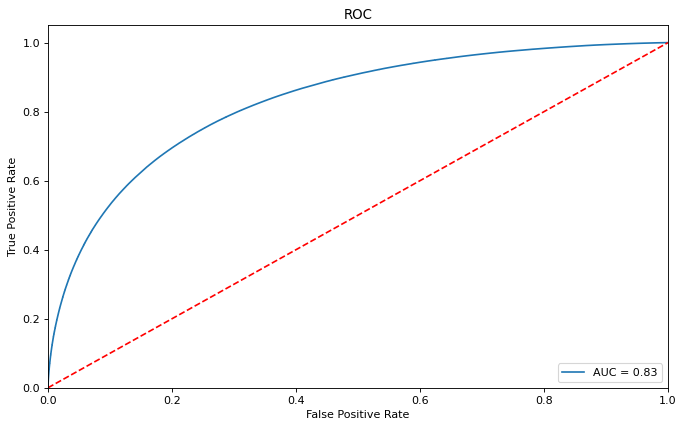

In [32]:

fpr, tpr, threshold = roc_curve(y_train, xg_2.predict(Dtrain))

# Calculate AUC (Area under curve) and ROC figure of the result

auc = metrics.auc(fpr, tpr)
print('AUC is:')
print(auc)
plt.figure(figsize=(10, 6), dpi=80)
plt.title('ROC')
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

best_threshold is: 0.49


0.909

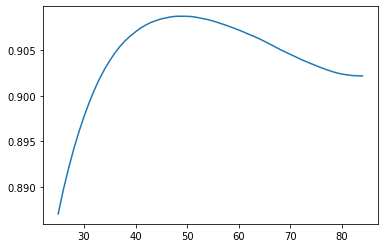

In [33]:
# Threshold
m = []
n = []
for i in range(25,85):
    threshold = i/100

    predicted_proba = xg_2.predict(Dtrain)
    predicted = (predicted_proba [:] >= threshold).astype('int')
    n.append(i)
    m.append(accuracy_score(y_train,predicted))

plt.plot(n,m)

# identify the best threshold
s = np.argsort(m)[::-1]
best_threshold = n[s[0]]
print('best_threshold is: %2.2f' % (best_threshold/100))

threshold = best_threshold/100

predicted_proba = xg_2.predict(Dtrain)
predicted = (predicted_proba [:] >= threshold).astype('int')
accuracy_score(y_train,predicted).round(3)

In [34]:
# Confusion Matrix

cm = pd.DataFrame({
                    'Yes':confusion_matrix(y_train, predicted)[:,0],
                    'No': confusion_matrix(y_train, predicted)[:,1]
})
s = [['Predicted','Predicted'],['Yes','No']]
cm.index = s
v = [['Actual','Actual'],['Yes','No']]
cm.columns = v
cm

Actual        
                   Yes      No
Predicted Yes  7564899   80938
          No    692294  136530

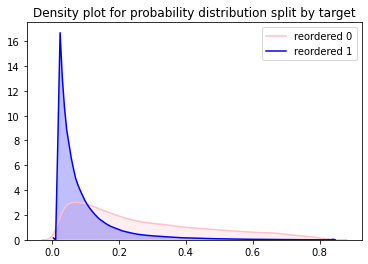

In [80]:
# distribution plot split by target variable

predicted_proba = xg_2.predict(Dtrain)
dist_df = pd.DataFrame({
    'target': y_train,
    'prob': predicted_proba
})

sns.kdeplot(dist_df['prob'][dist_df['target'] == 1], color = 'pink', shade = True)
sns.kdeplot(dist_df['prob'][dist_df['target'] == 0], color = 'blue', shade = True)

plt.legend(['reordered 0', 'reordered 1'])
plt.title('Density plot for probability distribution split by target')
ax.set(xlabel = 'Probability')
plt.show()
 

In [ ]:
## xgboost explainer explore



#### 4. Output

In [35]:
y_pred = (y_pred_prb [:] >= 0.49).astype('int')

In [40]:
output = pd.DataFrame({
    'user_id':test['user_id'],
    'product_id': test['product_id'],
    'reordered': y_pred
})
output.head(10)

,user_id,product_id,reordered
120,3,248,0
121,3,1005,0
122,3,1819,0
123,3,7503,0
124,3,8021,0
125,3,9387,0
126,3,12845,0
127,3,14992,0
128,3,15143,0
129,3,16797,0


In [41]:
output[output['reordered']==1]

,user_id,product_id,reordered
135,3,21903,1
143,3,39190,1
150,3,47766,1
535,12,13176,1
754,15,196,1
...,...,...,...
13307656,206207,36011,1
13307664,206207,39180,1
13307671,206207,44632,1
13307732,206208,13176,1
